In [2]:
reset -f

In [19]:
%matplotlib inline

from abc import ABC, abstractmethod

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import display, Markdown, Latex

# Protein sequence matching using Dynamic Programming algorithms

This notebook explores protein sequence matching strategies such as the Needleman-Wunsch and Smith-Waterman algorithms.

It also explores an Hidden Markov Model algorithm (Viterbi) for identifying hidden states, such as AT-rich or CG-rich regions.

### Utils

Memoization for the Needleman-Wunsch and Smith-Waterman algorithms

In [4]:
def memoize(f):
    memo = {}
    def helper(i, j):
        if (i, j) not in memo:
            memo[(i, j)] = f(i, j)
        return memo[(i,j)]
    return helper

### Abstract SequenceMatcher class

In [5]:
class SequenceMatcher(ABC):
    def __init__(self, a, b):
        
        # Column names for the BLOSUM50 matrix
        self.BLOSUM50_HEAD = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
        self.BLOSUM50_IDX = dict([[k, i] for i, k in enumerate(self.BLOSUM50_HEAD)])
        self.blosum50 = np.loadtxt('blosum50.txt', dtype=np.int8)
        
        # Sequence a
        self.a = list(a)
        
        # Sequence b
        self.b = list(b)

        self.tab = np.full((len(self.a)+1, len(self.b)+1), -np.inf)

        self.rows, self.cols = self.tab.shape
        
        self._s = lambda a, b: self.blosum50[self.BLOSUM50_IDX[a], self.BLOSUM50_IDX[b]]
        self._d = 8
    
    @abstractmethod
    def forward(self):
        pass
    
    @abstractmethod
    def backward(self):
        pass

## 1. Needleman-Wunsch edit distance for proteins

In [6]:
class NeedlemanWunsch(SequenceMatcher):
    def __init__(self, a, b):
        SequenceMatcher.__init__(self, a, b)
    
    def forward(self):
        @memoize
        def _F(i, j):
            if i == 0 and j == 0:
                return 0
            if i < 0 or j < 0:
                return -np.inf
            
            return max(_F(i-1, j-1) + self._s(self.a[i-1],self.b[j-1]),
                       _F(i-1, j) - self._d,
                       _F(i, j-1) - self._d)
        
        mat = [[_F(i,j) for j in range(self.cols)] for i in range(self.rows)]
        self.tab = np.array(mat)
        
    def backward(self):
        path = []
        curr_row, curr_col = self.tab.shape; curr_row -= 1; curr_col -= 1
        
        path.append((curr_row, curr_col))
        while (curr_row, curr_col) != (0,0):
            if self.tab[curr_row, curr_col] == self.tab[curr_row-1, curr_col-1] + self._s(self.a[curr_row-1], self.b[curr_col-1]):
                curr_row -= 1; curr_col -= 1
            elif self.tab[curr_row, curr_col] == self.tab[curr_row-1, curr_col] - self._d:
                curr_row -= 1
            else:
                curr_col -= 1
            path.append((curr_row, curr_col))
        
        self.path = path[::-1]

### a) Needleman-Wunsch for HEAGAWGHEE & PAWHEAE

In [7]:
nw = NeedlemanWunsch('HEAGAWGHEE', 'PAWHEAE')

In [10]:
nw.forward()
pd.DataFrame(nw.tab.T)

,0,1,2,3,4,5,6,7,8,9,10
0,0,-8,-16,-24,-32,-40,-48,-56,-64,-72,-80
1,-8,-2,-9,-17,-25,-33,-41,-49,-57,-65,-73
2,-16,-10,-3,-4,-12,-20,-28,-36,-44,-52,-60
3,-24,-18,-11,-6,-7,-15,-5,-13,-21,-29,-37
4,-32,-14,-18,-13,-8,-9,-13,-7,-3,-11,-19
5,-40,-22,-8,-16,-16,-9,-12,-15,-7,3,-5
6,-48,-30,-16,-3,-11,-11,-12,-12,-15,-5,2
7,-56,-38,-24,-11,-6,-12,-14,-15,-12,-9,1


In [11]:
nw.backward()
nw.path

[(0, 0),
 (1, 0),
 (2, 0),
 (3, 1),
 (4, 1),
 (5, 2),
 (6, 3),
 (7, 3),
 (8, 4),
 (9, 5),
 (9, 6),
 (10, 7)]

### b) Needleman-Wunsch PQPTTPVSSFTSGSMLGRTDTALTNTYSAL & PSPTMEAVEASTASHPHSTSSYFATTYYHL

In [12]:
nw2 = NeedlemanWunsch('PQPTTPVSSFTSGSMLGRTDTALTNTYSAL', 'PSPTMEAVEASTASHPHSTSSYFATTYYHL')

In [13]:
nw2.forward()
pd.DataFrame(nw2.tab.T)

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0,-8,-16,-24,-32,-40,-48,-56,-64,-72,...,-168,-176,-184,-192,-200,-208,-216,-224,-232,-240
1,-8,10,2,-6,-14,-22,-30,-38,-46,-54,...,-150,-158,-166,-174,-182,-190,-198,-206,-214,-222
2,-16,2,10,2,-4,-12,-20,-28,-33,-41,...,-137,-145,-153,-161,-169,-177,-185,-193,-201,-209
3,-24,-6,2,20,12,4,-2,-10,-18,-26,...,-122,-130,-138,-146,-154,-162,-170,-178,-186,-194
4,-32,-14,-6,12,25,17,9,1,-7,-15,...,-109,-117,-125,-133,-141,-149,-157,-165,-173,-181
5,-40,-22,-14,4,17,24,16,10,2,-6,...,-94,-102,-110,-118,-126,-134,-142,-150,-158,-166
6,-48,-30,-20,-4,9,16,23,15,9,1,...,-84,-92,-100,-108,-116,-124,-132,-140,-148,-156
7,-56,-38,-28,-12,1,9,15,23,16,10,...,-76,-79,-87,-95,-103,-111,-119,-127,-135,-143
8,-64,-46,-36,-20,-7,1,7,20,21,14,...,-70,-76,-78,-86,-94,-102,-110,-118,-126,-134
9,-72,-54,-44,-28,-15,-7,0,12,19,20,...,-63,-71,-79,-79,-86,-94,-102,-110,-118,-126


In [14]:
nw2.backward()
nw2.path

[(0, 0),
 (1, 1),
 (2, 2),
 (3, 3),
 (4, 4),
 (5, 5),
 (6, 6),
 (7, 7),
 (8, 8),
 (9, 9),
 (10, 10),
 (11, 11),
 (12, 12),
 (13, 13),
 (14, 14),
 (15, 15),
 (16, 16),
 (17, 17),
 (18, 18),
 (19, 19),
 (20, 20),
 (21, 21),
 (22, 22),
 (23, 23),
 (24, 24),
 (25, 25),
 (26, 26),
 (27, 27),
 (28, 28),
 (29, 29),
 (30, 30)]

## 2. Smith-Waterman Local Sequence Matching

In [15]:
class SmithWaterman(SequenceMatcher):
    def __init__(self, a, b):
        SequenceMatcher.__init__(self, a, b)
        
        
    def forward(self):
        @memoize
        def _F(i, j):
            if i == 0 and j == 0:
                return 0
            if i < 0 or j < 0:
                return -np.inf

            return max(_F(i-1, j-1) + self._s(self.a[i-1],self.b[j-1]),
                       _F(i-1, j) - self._d,
                       _F(i, j-1) - self._d,
                       0)

        mat = [[_F(i,j) for j in range(self.cols)] for i in range(self.rows)]
        self.tab = np.array(mat)
        self.start = np.unravel_index(self.tab.argmax(), self.tab.shape)
        
    
    def backward(self):
        path = []
        curr_row, curr_col = self.start
        
        path.append((curr_row, curr_col))
        while self.tab[curr_row, curr_col] != 0:
            if self.tab[curr_row, curr_col] == self.tab[curr_row-1, curr_col-1] + self._s(self.a[curr_row-1], self.b[curr_col-1]):
                curr_row -= 1; curr_col -= 1
            elif self.tab[curr_row, curr_col] == self.tab[curr_row-1, curr_col] - self._d:
                curr_row -= 1
            else:
                curr_col -= 1
            path.append((curr_row, curr_col))
        
        self.path = path[::-1]

### a) Smith-Waterman for HEAGAWGHEE & PAWHEAE

In [16]:
sw = SmithWaterman('HEAGAWGHEE', 'PAWHEAE')

In [17]:
sw.forward()
pd.DataFrame(sw.tab.T)

,0,1,2,3,4,5,6,7,8,9,10
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,5,0,5,0,0,0,0,0
3,0,0,0,0,2,0,20,12,4,0,0
4,0,10,2,0,0,0,12,18,22,14,6
5,0,2,16,8,0,0,4,10,18,28,20
6,0,0,8,21,13,5,0,4,10,20,27
7,0,0,6,13,18,12,4,0,4,16,26


In [20]:
display(Markdown('Backward algorithm start at: **{}** with value **{}**'.format(sw.start, sw.tab[sw.start])))

Backward algorithm start at: **(9, 5)** with value **28**

In [21]:
sw.backward()
sw.path

[(4, 1), (5, 2), (6, 3), (7, 3), (8, 4), (9, 5)]

### b) Smith-Waterman for MQNSHSGVNQLGGVFVNGRPLPDSTRQKIVELAHSGARPCDISRILQVSNGCVSKILGRY & TDDECHSGVNQLGGVFVGGRPLPDSTRQKIVELAHSGARPCDISRI

In [22]:
sw2 = SmithWaterman('MQNSHSGVNQLGGVFVNGRPLPDSTRQKIVELAHSGARPCDISRILQVSNGCVSKILGRY',
                    'TDDECHSGVNQLGGVFVGGRPLPDSTRQKIVELAHSGARPCDISRI')

In [23]:
sw2.forward()
pd.DataFrame(sw2.tab.T)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,2,0,2,0,0,0,...,0,0,0,2,0,0,0,0,0,0
2,0,0,0,2,0,1,0,1,0,2,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,2,2,0,1,0,0,2,...,3,0,0,0,0,0,0,0,0,0
4,0,0,2,0,1,2,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,0,0,1,0,0,0,...,0,13,5,0,0,0,0,0,0,0
6,0,0,1,1,0,10,2,0,0,1,...,0,5,9,4,0,0,0,0,0,2
7,0,0,0,2,6,2,15,7,0,1,...,1,0,3,14,6,0,0,0,0,0
8,0,0,0,0,2,4,7,23,15,7,...,9,1,0,6,12,4,0,8,0,0
9,0,1,0,0,0,0,2,15,28,20,...,1,8,6,0,4,16,8,0,5,0


In [24]:
display(Markdown('Backward algorithm start at: **{}** with value **{}**'.format(sw2.start, sw2.tab[sw2.start])))

Backward algorithm start at: **(45, 46)** with value **273**

In [25]:
sw2.backward()
sw2.path

[(4, 5),
 (5, 6),
 (6, 7),
 (7, 8),
 (8, 9),
 (9, 10),
 (10, 11),
 (11, 12),
 (12, 13),
 (13, 14),
 (14, 15),
 (15, 16),
 (16, 17),
 (17, 18),
 (18, 19),
 (19, 20),
 (20, 21),
 (21, 22),
 (22, 23),
 (23, 24),
 (24, 25),
 (25, 26),
 (26, 27),
 (27, 28),
 (28, 29),
 (29, 30),
 (30, 31),
 (31, 32),
 (32, 33),
 (33, 34),
 (34, 35),
 (35, 36),
 (36, 37),
 (37, 38),
 (38, 39),
 (39, 40),
 (40, 41),
 (41, 42),
 (42, 43),
 (43, 44),
 (44, 45),
 (45, 46)]

# 3. BLAST algorithm

Ran using Stephen F. Altschul, Thomas L. Madden, Alejandro A. Schäffer, Jinghui Zhang, Zheng Zhang, Webb Miller, and David J. Lipman (1997), "Gapped BLAST and PSI-BLAST: a new generation of protein database search programs", Nucleic Acids Res. 25:3389-3402.

Investigates sequence matching between the PAX6_MOUSE protein and the O96791_DROME protein for the Fruit Fly.

In [26]:
df_seq = pd.read_csv('9fktw4jw113-alignment-hittable.csv', header=None)
df_seq.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,sp|P63015|PAX6_MOUSE,tr|O96791|O96791_DROME,97.561,41,1,0,5,45,61,101,1.720000e-26,88.2,97.56
1,sp|P63015|PAX6_MOUSE,tr|O96791|O96791_DROME,26.667,30,22,0,300,329,26,55,2.100000e+00,13.9,36.67
2,sp|P63015|PAX6_MOUSE,tr|O96791|O96791_DROME,40.000,20,11,1,279,297,35,54,2.700000e+00,13.5,65.00
3,sp|P63015|PAX6_MOUSE,tr|O96791|O96791_DROME,31.250,16,11,0,361,376,27,42,5.200000e+00,12.7,50.00


In [27]:
import json
from pprint import pprint
json_string = open('9fktw4jw113-alignment.json', 'r').read()
json_seq = json.loads(json_string)

for i, result in enumerate(json_seq['BlastOutput2'][0]['report']['results']['bl2seq'][0]['hits'][0]['hsps']):
    print('[{i}]: bit_score: {bit_score:2f}; gaps: {gaps}; score={score}\n\thseq: {hseq}\n\tmidline: {midline}\n\tqseq: {qseq}'.\
         format(i=i,
                bit_score=result['bit_score'],
                gaps=result['gaps'],
                hseq=result['hseq'],
                midline=result['midline'],
                qseq=result['qseq'],
                score=result['score']))

[0]: bit_score: 88.196500; gaps: 0; score=217
	hseq: HSGVNQLGGVFVGGRPLPDSTRQKIVELAHSGARPCDISRI
	midline: HSGVNQLGGVFV GRPLPDSTRQKIVELAHSGARPCDISRI
	qseq: HSGVNQLGGVFVNGRPLPDSTRQKIVELAHSGARPCDISRI
[1]: bit_score: 13.853000; gaps: 0; score=24
	hseq: PSPTMEAVEASTASHPHSTSSYFATTYYHL
	midline: P PT         S    T      TY  L
	qseq: PQPTTPVSSFTSGSMLGRTDTALTNTYSAL
[2]: bit_score: 13.467800; gaps: 1; score=23
	hseq: ASTASHPHSTSSYFATTYYH
	midline:   T SH    SS F T  Y 
	qseq: SNTPSHIPISSS-FSTSVYQ
[3]: bit_score: 12.697400; gaps: 0; score=21
	hseq: SPTMEAVEASTASHPH
	midline: SP        T   PH
	qseq: SPSVNGRSYDTYTPPH


# 4. Viterbi HMM for CG rich regions

In [28]:
class Viterbi:
    def __init__(self, states, t_prob, em_prob, st_prob, observations):
        '''Initialize a new HMM with the following parameters
        # Arguments:
            states: possible states in which the HMM can be in
            t_prob: transition probability from each state
                to another state
            em_prob: probability of emitting a character at a
                given state
            st_prob: probability of starting in a state
            observations: observed sequence
        '''
        self.states = states
        self.t_prob = t_prob
        self.em_prob = em_prob
        self.st_prob = st_prob
        self.observations = observations
        
        # Dictionary for forward pass
        self.v = dict([[k,{}] for k in self.states])
        
        self.sub_path = dict([[k, []] for k in self.states])
        self.path = []
    
    def _v_i(self, t, csi=None, i=None):
        if t == 0:
            if i == states[0]:
                return 0
            else:
                # 0 + epsilon (as Log(0) undefined)
                return -np.inf
        e_i = self.em_prob[i][csi]
        
        '''
        self.v_at & self.v_cg are already logartithms, so we only need to sum them 
        with the log of the transition probabilities
        '''
        v_js = [v[t-1] + np.log(self.t_prob[i][state]) for state, v in self.v.items()]
        v_j = np.max(v_js)
        v_ptr = np.argmax(v_js)
        v_i = np.log(e_i) + v_j
        
        self.sub_path[i].append(v_ptr)
        
        return v_i
    
    def forward(self):
        for state, v in self.v.items():
            v[0] = self._v_i(0, csi='N/A', i=state)
        for t, k in enumerate(self.observations, 1):
            for state, v in self.v.items():
                v[t] = self._v_i(t, csi=k, i=state)
        
    def backward(self):
        q_T = self.states[np.argmax([list(v.values())[-1] for v in self.v.values()])]
        self.path.append(q_T)
        for i in range(len(self.sub_path[q_T])-1,0,-1):
            q_T_prev = self.sub_path[q_T][i]
            q_T_prev = self.states[q_T_prev]
            self.path.append(q_T_prev)
            q_T = q_T_prev
        
    def save_path_to_file(self, file_name='viterbi_path.txt', map_fct=lambda x: x):
        mapped_path = list(map(map_fct, self.path))
        print_path = ''.join(mapped_path)
        with open(file_name, 'w') as file:
            file.write(print_path)

### Test Viterbi for Dishonest Casino example

In [42]:
states = ['Honest', 'Dishonest']
t_prob = {
    'Honest': {'Honest': 0.9, 'Dishonest': 0.1},
    'Dishonest': {'Honest': 0.1, 'Dishonest': 0.9}
}
em_prob = {
    'Honest': {'1': 1/6, '2': 1/6, '3': 1/6, '4': 1/6, '5': 1/6, '6': 1/6},
    'Dishonest': {'1': 1/10, '2': 1/10, '3': 1/10, '4': 1/10, '5': 1/10, '6': 1/2}
}
st_prob = {'Honest': 0.5, 'Dishonest': 0.5}
observations = [i for i in '5453525456666664365666635661416626365666621166211311155566351166565663466653642535666662541345464155']

In [43]:
vtb_casino = Viterbi(states=states, t_prob=t_prob, em_prob=em_prob, st_prob=None, observations=observations)

In [44]:
vtb_casino.forward()
vtb_casino.backward()

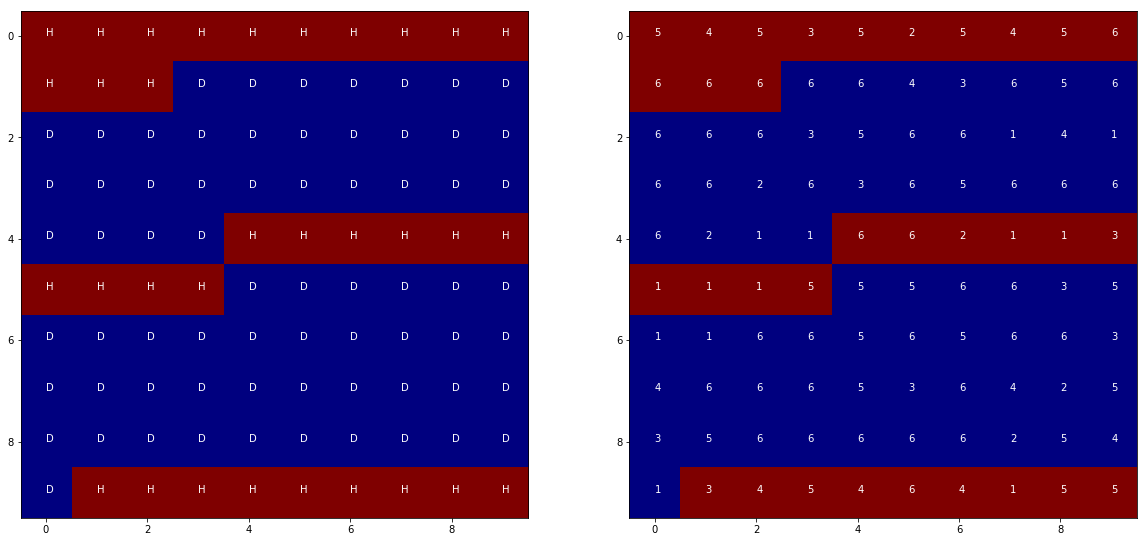

In [45]:
print_casino = np.reshape(np.array([1 if thing == 'Honest' else 0 for thing in vtb_casino.path]), (-1, 10))
short_path = ['H' if thing == 'Honest' else 'D' for thing in vtb_casino.path]
fig, ax = plt.subplots(1,2,figsize=(20,10))
for i in range(print_casino.shape[0]):
    for j in range(print_casino.shape[1]):
        ax[0].text(i, j, short_path[i+j*10], color='w')
ax[0].imshow(print_casino, cmap='jet')

for i in range(print_casino.shape[0]):
    for j in range(print_casino.shape[1]):
        ax[1].text(i, j, vtb_casino.observations[i+j*10], color='w')
ax[1].imshow(print_casino, cmap='jet')

In [46]:
map_funct = lambda x: 'H' if x == 'Honest' else 'D'
vtb_casino.save_path_to_file('viterbi_casino.txt', map_fct=map_funct)

### Viterbi on the Phase Lambda

In [47]:
states = ['AT rich', 'CG rich']
t_prob = {
    'AT rich': {'AT rich': 0.9998, 'CG rich': 0.0002},
    'CG rich': {'AT rich': 0.0003, 'CG rich': 0.9997}
}
em_prob = {
    'AT rich': {'A': 0.2698, 'T': 0.3237, 'C': 0.208, 'G': 0.1985},
    'CG rich': {'A': 0.2079, 'T': 0.2079, 'C': 0.2478, 'G': 0.2984}
}
sequence_fasta = open('sequence.fasta', 'r').read()
sequence = ''.join(sequence_fasta.strip().split('\n')[1:])
observations = [i for i in sequence]
observations[0:15]

['G', 'G', 'G', 'C', 'G', 'G', 'C', 'G', 'A', 'C', 'C', 'T', 'C', 'G', 'C']

In [48]:
vtb_lambda = Viterbi(states=states, t_prob=t_prob, em_prob=em_prob, st_prob=None, observations=observations)

In [49]:
vtb_lambda.forward()
vtb_lambda.backward()

In [50]:
map_fct = lambda x : 'A' if x == 'AT rich' else 'G'
vtb_lambda.save_path_to_file('viterbi_lambda.txt', map_fct=map_fct)

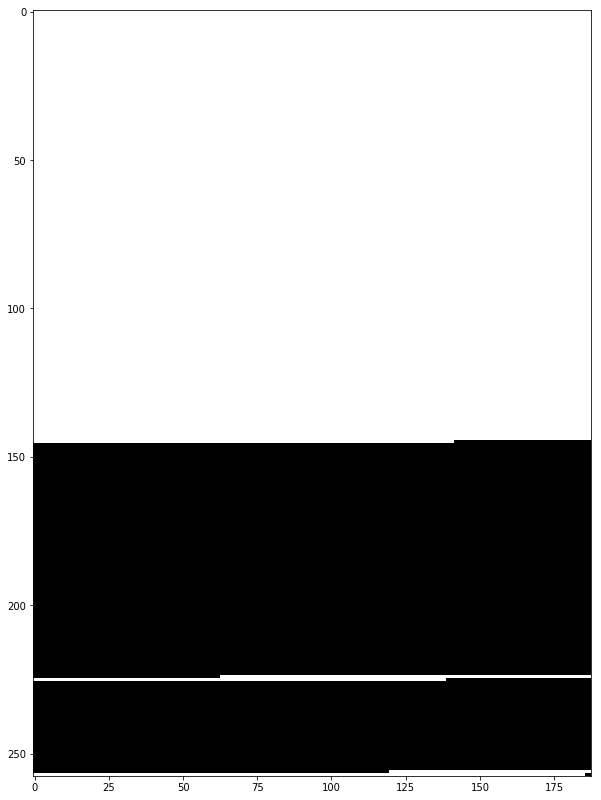

In [51]:
print_seq = [1 if thing == 'AT rich' else 0 for thing in vtb_lambda.path]
print_seq = np.array(print_seq)
print_seq = np.concatenate((print_seq, np.zeros(2)))
print_seq = np.reshape(print_seq, (-1, 188))

fig, ax = plt.subplots(figsize=(10,20))
ax.imshow(print_seq, cmap='gray')

**Legend**: 
- _white_: AT rich region
- _black_: CG rich region